<a href="https://colab.research.google.com/github/caxaxa/SigmaGeek_Cellular_Automata/blob/main/Copy_of_Sigma_Geek_Cellular_Atutomata_Fase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Celular Automata Maze

In [1]:

#!pip install pycuda

In [2]:
#!pip install cupy

In [3]:
import cupy as cp
from cupyx.scipy.signal import convolve2d
import matplotlib.pyplot as plt

import numpy as np

In [4]:

#get the second grid from the game
import urllib.request


url = "https://s3.amazonaws.com/appforest_uf/f1680523122184x750475284910287400/input1.txt"
response = urllib.request.urlopen(url)
grid0 = cp.loadtxt(response, delimiter=" ")



In [5]:
grid0

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [6]:
# Define a function to plot a grid
def simple_plot_grid(grid):
    n_rows, n_cols = grid.shape
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(cp.asnumpy(grid), cmap="Greens", extent=[0, n_cols, 0, n_rows], origin="lower") # set cmap to "Greens"
    ax.grid(color="gray", linewidth=0.5)
    plt.show()

    return fig, ax

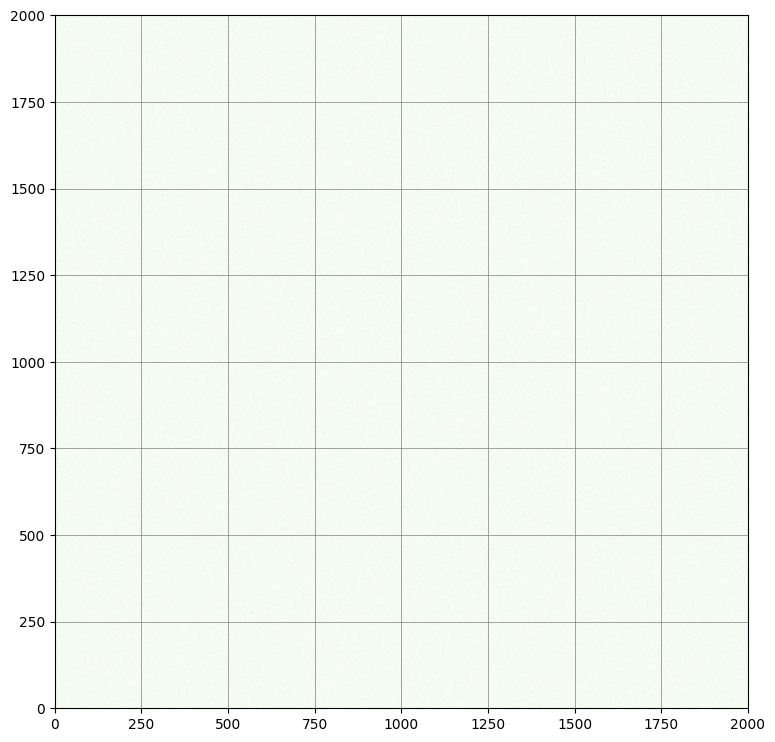

(<Figure size 900x900 with 1 Axes>, <Axes: >)

In [7]:
simple_plot_grid(grid0)

In [8]:
def apply_rule(center, neighbors):
    # Count the number of green neighbors
    green_neighbors = np.count_nonzero(neighbors)
    # Apply the appropriate rule based on the center cell's color and the number of green neighbors
    if center == 0:
        # White cell rule
        if green_neighbors > 1 and green_neighbors < 5:
            return 1  # Turn white cell green
        else:
            return 0  # Keep white cell white
    elif center == 1:
        # Green cell rule
        if green_neighbors > 3 and green_neighbors < 6:
            return 1  # Keep green cell green
        else:
            return 0  # Turn green cell white
    else:
      return center

In [9]:
# import numpy as np
# from scipy.signal import convolve2d

# def next_generation(grid):
#     # Define function to apply the rules to each cell
#     kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])

#     # Apply the additional rule to set the neighbor value to 0 if the grid value is greater than 1
#     grid = np.where(grid > 1, 0, grid)

#     # Convolve the grid with the kernel to count the number of live neighbors for each cell
#     neighbor_count = convolve2d(grid, kernel, mode='same', boundary='wrap')

#     # Apply the rules to each cell to generate the new grid
#     new_grid = np.zeros_like(grid)
#     white_rule = np.logical_and(neighbor_count > 1, neighbor_count < 5)
#     green_rule = np.logical_and(neighbor_count > 3, neighbor_count < 6)
#     new_grid[(grid == 0) & white_rule] = 1
#     new_grid[(grid == 1) & green_rule] = 1
    
#     # Return the new grid representing the next generation
#     return new_grid.astype(np.int8)


In [10]:
import cupy as cp
from scipy.signal import convolve2d

import cupyx

def next_generation(grid):
    # Define function to apply the rules to each cell
    kernel = cp.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])

    # FIX THIS RULE.... IT NEED TO MAINTAIN THE VALUE AS 3 OR4
    grid = cp.where(grid > 1, 0, grid)

    # Convolve the grid with the kernel to count the number of live neighbors for each cell
    neighbor_count = cupyx.scipy.ndimage.convolve(grid, kernel, mode='wrap')

    # Apply the rules to each cell to generate the new grid
    new_grid = cp.zeros_like(grid)
    white_rule = cp.logical_and(neighbor_count > 1, neighbor_count < 5)
    green_rule = cp.logical_and(neighbor_count > 3, neighbor_count < 6)
    new_grid[(grid == 0) & white_rule] = 1
    new_grid[(grid == 1) & green_rule] = 1
    
    # Return the new grid representing the next generation
    return new_grid.astype(cp.int8)

In [11]:
#make a function to generate an array of grids to be the input on the A* algo

def generate_grids(grid0, n):
    # Create an array of grids to store the results
    grids = cp.zeros((n, grid0.shape[0], grid0.shape[1]), dtype=cp.int8)
    grids[0] = cp.array(grid0)

    # Generate the subsequent grids using the next_generation function
    for i in range(1, n):
        grids[i] = next_generation(grids[i-1])

    return grids

In [12]:
grids =  generate_grids(grid0, 300)

In [13]:
# from typing import List

# # Node class representing a single point in the grid
# class Node:
#     # Constructor for Node class
#     def __init__(self, position, step, g_score=float('inf'), h_score=float('inf'), parent=None):
#         self.position = position  # Tuple (x, y) representing the position of the node in the grid
#         self.step = step  # Step associated with the grid
#         self.g_score = g_score  # Cost from the start node to the current node
#         self.h_score = h_score  # Heuristic cost from the current node to the goal node
#         self.f_score = g_score + h_score  # Total estimated cost of the path through the current node
#         self.parent = parent  # Parent node in the path

#     # Equality comparison method
#     def __eq__(self, other):
#         return self.position == other.position and self.step == other.step

#     # Less than comparison method
#     def __lt__(self, other):
#         return self.f_score < other.f_score or (self.f_score == other.f_score and self.h_score < other.h_score)

#     # Hash method for hashing nodes based on their position and step
#     def __hash__(self):
#         return hash((self.position, self.step))

# # Function to reconstruct the path from the goal node to the start node
# def reconstruct_path(node):
#     path = [(node.position, node.step)]
#     while node.parent is not None:
#         node = node.parent
#         path.append((node.position, node.step))
#     return path[::-1]  # Reverse the path so it starts from the start node


In [14]:
# import cupy as cp
# # A* search algorithm implementation
# def a_star(grids: List[List[int]], start: Node, goal: tuple) -> List[tuple]:
#     open_set = [start]  # Initialize the open set with the start node
#     closed_set = set()  # Initialize an empty closed set

#     while open_set:  # Continue the search while there are nodes in the open set
#         # Find the node with the lowest f_score in the open set
#         current = min(open_set, key=lambda node: node.f_score)
#         if current.position == goal:  # If the current node is the goal node, return the path
#             return reconstruct_path(current)

#         open_set.remove(current)  # Remove the current node from the open set
#         closed_set.add(current)  # Add the current node to the closed set

#         # Loop through the neighbors of the current node
#         # Loop through the neighbors of the current node
#         for dx, dy in ((0, 1), (0, -1), (1, 0), (-1, 0)):
#             x, y = current.position[0] + dx, current.position[1] + dy
#             if x < 0 or x >= len(grids[0]) or y< 0 or y >= len(grids[0][0]):
#                 continue  # Skip if the neighbor is out of grid boundaries

#             successor_step = (current.step + 1) % len(grids)
#             grid = cp.asarray(grids[successor_step])
#             if grid[x][y] != 0:  # If the grid cell is not traversable, skip this neighbor
#                 continue

#             # Create a successor node with the current node as its parent
#             successor = Node(position=(x, y), step=successor_step, parent=current)
#             if successor in closed_set:  # Skip if the successor node is already in the closed set
#                 continue

#             tentative_g_score = current.g_score + 1  # Calculate the tentative g_score for the successor node

#             if successor in open_set:  # If the successor is already in the open set, update its scores if needed
#                 if tentative_g_score < successor.g_score:
#                     successor.g_score = tentative_g_score
#                     successor.h_score = cp.abs(x - goal[0]) + cp.abs(y - goal[1])
#                     successor.f_score = successor.g_score + successor.h_score
#                     successor.parent = current
#             else:  # If the successor is not in the open set, calculate its scores and add it to the open set
#                 successor.g_score = tentative_g_score
#                 successor.h_score = cp.abs(x - goal[0]) + cp.abs(y - goal[1])
#                 successor.f_score = successor.g_score + successor.h_score
#                 open_set.append(successor)

#     return 'No Paths to the goal in {} steps.'.format(len(grids))  # If there is no path to the goal, return None

In [15]:
# import numpy as np
# import cupy as cp
# from cupyx.scipy.sparse import csr_matrix

# def dijkstra_cusparse(graph, start):
#     # Create a CSR matrix representation of the graph
#     csr_graph = csr_matrix(graph)

#     # Initialize the distance array and the visited set
#     n = len(graph)
#     dist = cp.full(n, np.inf)
#     visited = cp.zeros(n, dtype=bool)
#     dist[start] = 0

#     # Initialize the cusparse library
#     handle = cp.cuda.cusparse.create()

#     # Create the CSR matrix descriptor
#     descr = cp.cuda.cusparse.createMatDescr()
#     cp.cuda.cusparse.setMatType(descr, cp.cuda.cusparse.MAT_TYPE_GENERAL)
#     cp.cuda.cusparse.setMatIndexBase(descr, cp.cuda.cusparse.INDEX_BASE_ZERO)

#     # Run Dijkstra's algorithm
#     for i in range(n):
#         # Find the vertex with the minimum distance that has not been visited yet
#         min_dist = np.inf
#         min_vertex = -1
#         for j in range(n):
#             if not visited[j] and dist[j] < min_dist:
#                 min_dist = dist[j]
#                 min_vertex = j
#         visited[min_vertex] = True

#         # Update the distances of the neighboring vertices
#         for j in range(csr_graph.indptr[min_vertex], csr_graph.indptr[min_vertex+1]):
#             neighbor = csr_graph.indices[j]
#             if not visited[neighbor]:
#                 new_dist = dist[min_vertex] + csr_graph.data[j]
#                 if new_dist < dist[neighbor]:
#                     dist[neighbor] = new_dist

#     # Release the cusparse handle and the matrix descriptor
#     cp.cuda.cusparse.destroy(handle)
#     cp.cuda.cusparse.destroyMatDescr(descr)

#     return dist

In [16]:
# import cupy as cp
# from cupyx.scipy.sparse import csr_matrix

# # A* search algorithm implementation
# def a_star(grids: List[List[int]], start: Node, goal: tuple) -> List[tuple]:
#     n_steps = len(grids)
#     grid_shape = (len(grids[0]), len(grids[0][0]))

#     # Create a sparse matrix representing the grid
#     matrix_data = []
#     matrix_row = []
#     matrix_col = []
#     for i in range(n_steps):
#         for x in range(grid_shape[0]):
#             for y in range(grid_shape[1]):
#                 index = x * grid_shape[1] + y + i * grid_shape[0] * grid_shape[1]
#                 if grids[i][x][y] == 0:
#                     matrix_data.append(1)
#                 else:
#                     matrix_data.append(0)

#                 if x < grid_shape[0] - 1 and grids[i][x + 1][y] == 0:
#                     matrix_data.append(1)
#                     matrix_row.append(index)
#                     matrix_col.append(index + grid_shape[1])
#                 if y < grid_shape[1] - 1 and grids[i][x][y + 1] == 0:
#                     matrix_data.append(1)
#                     matrix_row.append(index)
#                     matrix_col.append(index + 1)
#                 if i < n_steps - 1 and grids[i + 1][x][y] == 0:
#                     matrix_data.append(1)
#                     matrix_row.append(index)
#                     matrix_col.append(index + grid_shape[0] * grid_shape[1])

#     matrix = csr_matrix((matrix_data, (matrix_row, matrix_col)), shape=(n_steps * grid_shape[0] * grid_shape[1],) * 2)

#     # Find the start and goal node indices
#     start_index = start.position[0] * grid_shape[1] + start.position[1] + start.step * grid_shape[0] * grid_shape[1]
#     goal_index = goal[0] * grid_shape[1] + goal[1]

#     # Perform Dijkstra's algorithm on the sparse matrix to find the shortest path
#     dist, prev = dijkstra(matrix, indices=start_index, return_predecessors=True)

#     # Reconstruct the path from the start to the goal node
#     path = [(goal[0], goal[1])]
#     node_index = goal_index
#     while node_index != start_index:
#         node_index = prev[node_index]
#         step = node_index // (grid_shape[0] * grid_shape[1])
#         x = (node_index % (grid_shape[0] * grid_shape[1])) // grid_shape[1]
#         y = (node_index % (grid_shape[0] * grid_shape[1])) % grid_shape[1]
#         path.append((x, y))
#     path.append(start.position[::-1])

#     return path[::-1]

In [17]:
# import pycuda.autoinit
# import pycuda.driver as cuda

# from pycuda.compiler import SourceModule

# # Define the CUDA kernel for computing scores for all neighbors in parallel
# kernel = SourceModule('''
#     #define BLOCK_SIZE 256
#     __global__ void compute_scores(int *grid, int *positions, int *steps, float *g_scores, float *h_scores, float *f_scores, int *parents, int *dx, int *dy, int num_neighbors, int grid_width, int grid_height, int successor_step, int current_idx, float current_g_score, int goal_x, int goal_y) {
#         __shared__ int shared_grid[BLOCK_SIZE];
#         int idx = blockIdx.x * blockDim.x + threadIdx.x;
#         int x = positions[current_idx] + dx[idx % num_neighbors];
#         int y = positions[current_idx + 1] + dy[idx % num_neighbors];
#         if (x >= 0 && x < grid_width && y >= 0 && y < grid_height) {
#             int neighbor_grid_idx = successor_step * grid_width * grid_height + y * grid_width + x;
#             if (idx < num_neighbors) {
#                 shared_grid[threadIdx.x] = grid[neighbor_grid_idx];
#             }
#             __syncthreads();
#             if (shared_grid[threadIdx.x % num_neighbors] == 0) {
#                 int successor_idx = (current_idx + idx % num_neighbors + 2) % (num_neighbors * 2);
#                 float tentative_g_score = current_g_score + 1;
#                 float h_score = abs(x - goal_x) + abs(y - goal_y);
#                 float f_score = tentative_g_score + h_score;
#                 if (f_score < f_scores[successor_idx]) {
#                     g_scores[successor_idx] = tentative_g_score;
#                     h_scores[successor_idx] = h_score;
#                     f_scores[successor_idx] = f_score;
#                     parents[successor_idx] = current_idx;
#                     positions[successor_idx * 2] = x;
#                     positions[successor_idx * 2 + 1] = y;
#                     steps[successor_idx] = successor_step;
#                 }
#             }
#         }
#     }
# ''')


In [18]:
# import pycuda.autoinit
# import pycuda.driver as cuda
# from pycuda.compiler import SourceModule
# import numpy as np
# from typing import List, Tuple

# class Node:
#     def __init__(self, position: Tuple[int, int], step: int, g_score: float, h_score: float, f_score: float, parent=None):
#         self.position = position
#         self.step = step
#         self.g_score = g_score
#         self.h_score = h_score
#         self.f_score = f_score
#         self.parent = parent

# def a_star_gpu(grids: List[List[int]], start: Node, goal: Tuple[int, int]) -> List[Tuple[int, int]]:
#     # Initialize the CUDA device and kernel
#     dx = np.array([0, 0, 1, -1], dtype=np.int32)
#     dy = np.array([1, -1, 0, 0], dtype=np.int32)
#     compute_scores_kernel = kernel.get_function('compute_scores')

#     # Initialize the GPU arrays
#     grid_gpu = cuda.to_device(grids.tobytes())
#     positions_gpu = cuda.to_device(np.array([start.position[0], start.position[1], -1, -1, -1, -1, -1, -1], dtype=np.int32))
#     steps_gpu = cuda.to_device(np.array([start.step, -1, -1, -1, -1, -1, -1, -1], dtype=np.int32))
#     g_scores_gpu = cuda.to_device(np.array([start.g_score, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float32))
#     h_scores_gpu = cuda.to_device(np.array([start.h_score, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float32))
#     f_scores_gpu = cuda.to_device(np.array([start.f_score, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float32))
#     parents_gpu = cuda.to_device(np.array([-1, -1, -1, -1, -1, -1, -1, -1], dtype=np.int32))
#     # Initialize the CPU data structures
#     open_list = [start]
#     closed_list = set()

#     # Initialize the search parameters
#     num_neighbors = len(dx)
#     successor_step = (start.step + 1) % 2
#     goal_x, goal_y = goal

#     # Loop until the open list is empty or the goal node is found
#     while open_list:
#         # Get the node with the lowest f_score from the open list
#         current = min(open_list, key=lambda node: node.f_score)

#         # Check if the current node is the goal node
#         if current.position == goal:
#             # Reconstruct the path from the goal node to the start node
#             path = []
#             while current is not None:
#                 path.append(current.position)
#                 current = current.parent
#             path.reverse()
#             return path

#         # Move the current node from the open list to the closed list
#         open_list.remove(current)
#         closed_list.add(current)

#         # Compute the scores for all neighbors of the current node in parallel using PyCUDA

#         #positions_cpu = cuda.from_device(positions_gpu, (len(positions), 2), dtype=np.int32)


#         current_idx = np.argwhere((cuda.from_device(positions_gpu, (8, 2), dtype=np.int32, order='F')[:, 0] == current.position[0]) & (cuda.from_device(positions_gpu, (8, 2), dtype=np.int32, order='F')[:, 1] == current.position[1]))[0][0]



#         compute_scores_kernel(grid_gpu, positions_gpu, steps_gpu, g_scores_gpu, h_scores_gpu, f_scores_gpu, parents_gpu, dx, dy, np.int32(num_neighbors), np.int32(len(grids[0])), np.int32(len(grids)), np.int32(successor_step), np.int32(current_idx), np.float32(current.g_score), np.int32(goal_x), np.int32(goal_y), block=(256,1,1), grid=((num_neighbors+255)//256, 1))
#                 # Copy the results back to the CPU
#         positions = positions_gpu.get()
#         steps = steps_gpu.get()
#         g_scores = g_scores_gpu.get()
#         h_scores = h_scores_gpu.get()
#         f_scores = f_scores_gpu.get()
#         parents = parents_gpu.get()

#         # Update the open list with the newly discovered nodes
#         for i in range(num_neighbors):
#             neighbor_idx = (current_idx + i + 2) % (num_neighbors * 2)
#             if f_scores[neighbor_idx] < np.inf:
#                 neighbor_position = (positions[neighbor_idx * 2], positions[neighbor_idx * 2 + 1])
#                 neighbor_step = steps[neighbor_idx]
#                 neighbor_g_score = g_scores[neighbor_idx]
#                 neighbor_h_score = h_scores[neighbor_idx]
#                 neighbor_f_score = f_scores[neighbor_idx]
#                 neighbor_parent_idx = parents[neighbor_idx]
#                 if neighbor_position not in [node.position for node in open_list + closed_list]:
#                     neighbor_node = Node(neighbor_position, neighbor_step, neighbor_g_score, neighbor_h_score, neighbor_f_score, current)
#                     open_list.append(neighbor_node)
#                 elif neighbor_g_score < [node.g_score for node in open_list + closed_list if node.position == neighbor_position][0]:
#                     [node for node in open_list + closed_list if node.position == neighbor_position][0].g_score = neighbor_g_score
#                     [node for node in open_list + closed_list if node.position == neighbor_position][0].f_score = neighbor_f_score
#                     [node for node in open_list + closed_list if node.position == neighbor_position][0].parent = current

#         # Switch to the other step
#         successor_step = (successor_step + 1) % 2

#     # If the open list is empty and the goal node was not found, return an empty path
#     return []




In [19]:


# Node class representing a single point in the grid
class Node:
    # Constructor for Node class
    def __init__(self, position, step, g_score=float('inf'), h_score=float('inf'), parent=None):
        self.position = position  # Tuple (x, y) representing the position of the node in the grid
        self.step = step  # Step associated with the grid
        self.g_score = g_score  # Cost from the start node to the current node
        self.h_score = h_score  # Heuristic cost from the current node to the goal node
        self.f_score = g_score + h_score  # Total estimated cost of the path through the current node
        self.parent = parent  # Parent node in the path

    # Equality comparison method
    def __eq__(self, other):
        return self.position == other.position and self.step == other.step

    # Less than comparison method
    def __lt__(self, other):
        return self.f_score < other.f_score or (self.f_score == other.f_score and self.h_score < other.h_score)

    # Hash method for hashing nodes based on their position and step
    def __hash__(self):
        return hash((self.position, self.step))

# Function to reconstruct the path from the goal node to the start node
def reconstruct_path(node):
    path = [(node.position, node.step)]
    while node.parent is not None:
        node = node.parent
        path.append((node.position, node.step))
    return path[::-1]  # Reverse the path so it starts from the start node

# A* search algorithm implementation
def a_star(grid0):
    m,n = grid0.shape
    start = Node(position=(0, 0), step=0, g_score=0, h_score=abs(0 - m) + abs(0 - n) )   
    goal = (m-1,n-1)
    open_set = [start]  # Initialize the open set with the start node
    closed_set = set()  # Initialize an empty closed set
    grids = cp.array([grid0])
    grids = cp.append(grids,next_generation(grid0)[np.newaxis,:,:], axis = 0 )

    while open_set:  # Continue the search while there are nodes in the open set
        # Find the node with the lowest f_score in the open set
        current = min(open_set, key=lambda node: node.f_score)
        grids = cp.append(grids,next_generation(grids[-1])[np.newaxis,:,:], axis = 0 )
        if current.position == goal:  # If the current node is the goal node, return the path
            return reconstruct_path(current)

        open_set.remove(current)  # Remove the current node from the open set
        closed_set.add(current)  # Add the current node to the closed set

        # Loop through the neighbors of the current node
        for dx, dy in ((0, 1), (0, -1), (1, 0), (-1, 0)):
            x, y = current.position[0] + dx, current.position[1] + dy
            if x < 0 or x >= len(grid0) or y< 0 or y >= len(grid0[0]):
                continue  # Skip if the neighbor is out of grid boundaries
            
            successor_step = (current.step + 1) 
            
            grid = grids[successor_step]
            if grid[x][y] != 0:  # If the grid cell is not traversable, skip this neighbor
                continue

            # Create a successor node with the current node as its parent
            successor = Node(position=(x, y), step=successor_step, parent=current)
            if successor in closed_set:  # Skip if the successor node is already in the closed set
                continue

            tentative_g_score = current.g_score + 1  # Calculate the tentative g_score for the successor node

            if successor in open_set:  # If the successor is already in the open set, update its scores if needed
                if tentative_g_score < successor.g_score:
                    successor.g_score = tentative_g_score
                    successor.h_score = abs(x - goal[0]) + abs(y - goal[1])
                    successor.f_score = successor.g_score + successor.h_score
                    successor.parent = current
            else:  # If the successor is not in the open set, calculate its scores and add it to the open set
                successor.g_score = tentative_g_score
                successor.h_score = abs(x - goal[0]) + abs(y - goal[1])
                successor.f_score = successor.g_score + successor.h_score
                open_set.append(successor)
    

    return 'No Paths to the goal in  steps.'  # If there is no path to the goal, return None



In [20]:
import time


# Measure the time it takes to run the function
start_time = time.time()
path = a_star(grid0)
end_time = time.time()

# Print the result and the time it took to run the function
print(path)
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

OutOfMemoryError: ignored

In [ ]:
#get only the coordenates from the pair position, step
path_points = [t[0] for t in path]
print(path_points) 
print('The solution has {} steps.'.format(len(path_points)))

In [ ]:
# Make a function to create the solution as required for the chalange
def path_to_solution(path):
    solution = ''
    for i in range(len(path) - 1):
        curr_pos = path[i][0]
        next_pos = path[i+1][0]
        if next_pos[1] > curr_pos[1]:
            solution += ' R'
        elif next_pos[1] < curr_pos[1]:
            solution += ' L'
        elif next_pos[0] > curr_pos[0]:
            solution += ' D'
        else:
            solution += ' U'
    return solution





In [ ]:
 sol = path_to_solution(path)

 with open("sol.txt", "w") as file:
    file.write(sol)

 print(sol)

## Vizualization and Testing

1 - Create an animation of the grid change and the point path; and

2- Check if the solution does not overlaps green cells at any point in the path.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import cupy as cp


def create_animation(grid0, n, update, plot_grid, path):
    frames = [grid0]

    for i in range(n-1):
        new_frame = update(frames[-1])
        frames.append(new_frame)

    def update_plot(frame_number, frames, ax):
        ax.clear()
        grid = cp.asnumpy(frames[frame_number])  # Convert the Cupy array to a NumPy array
        artists, update_point = plot_grid(grid, ax)
        return update_point(path[frame_number])  # Update the point for the current frame and return the artists

    fig, ax = plt.subplots()
    ani = animation.FuncAnimation(fig, update_plot, n, fargs=(frames, ax), interval=200, blit=True)

    return ani


def plot_grid(grid, ax):
    # Create a custom colormap
    cmap = mcolors.ListedColormap(['white', 'green', 'yellow'])
    bounds = [-0.5, 0.5, 1.5, np.max(cp.asnumpy(grid)) + 0.5]  # Convert the Cupy array to a NumPy array
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the grid with the custom colormap
    ax.imshow(cp.asnumpy(grid), cmap=cmap, norm=norm, aspect='auto')  # Convert the Cupy array to a NumPy array

    # Function to update the point color based on the given point (x, y)
    def update_point(point):
        y, x = point
        if cp.asnumpy(grid[y, x]) == 0:  # Convert the Cupy array to a NumPy array
            point_color = 'black'
        else:
            point_color = 'red'
        point_artist, = ax.plot(x, y, 'o', markersize=10, color=point_color)  # Use the specified color for the point
        ax.set_title(f'Point: {point}')
        return [point_artist]

    return ax, update_point


In [ ]:
ani = create_animation(grid0, len(path_points), next_generation, plot_grid, path_points)

In [ ]:
# To vizalise on jupyter notebook
from IPython.display import HTML


# Define a function to display the animation in HTML
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())

# Display the animation
display_animation(ani)

In [ ]:
# Saving the solution
ani.save('my_sol.mp4')

In [ ]:
print('g')